Distributions of distances for cis and trans pairs.

In [2]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pybedtools as pbt
import random, os
import numpy as np
from multiprocessing import Pool
from scipy import stats

pbt.set_tempdir('../../tmp')

In [3]:
#Input
data_path = "../../data/haplotype_HiC/bam/all_reads/"

#Output
tables = "../../results/csv/"
figures = "../../results/fig/"

In [4]:
def check_interaction_type(row):
    if row["same haplotype"] == False:
        if row["chrom1"] == row["chrom2"]:
            return "transh"
        else:
            return "trans-nonh"
    else:
        if row["chrom1"] == row["chrom2"]:
            return "cish " + row["h1"]
        else:
            return "cis-nonh"

In [5]:
def generate_second_from_pair(chrom):
    """Draw one random read from the selected chromosome. Return start position"""
    dm6_chromsizes = pbt.helpers.chromsizes("dm6")
    try:
        chromosome_size = dm6_chromsizes[chrom][1]
        read_position = random.randint(1,chromosome_size)
        return read_position
    except KeyError:
        #print(chrom)
        pass #ignore missing scaffolds

In [6]:
def read_and_preprocess(f):
    pairs = pd.read_csv(f, sep = "\t")
    pairs = pairs.rename(columns = {"haplotype1":"h1", "haplotype2":"h2"})
    
    #to have chromosome names consistent with genomic features
    pairs["chrom1"] = "chr" + pairs["chrom1"]
    pairs["chrom2"] = "chr" + pairs["chrom2"]
    pairs["interaction_ID"] = pairs.index
    pairs["same haplotype"] = pairs["h1"] == pairs["h2"]   
    pairs["interaction type"] = pairs.apply(check_interaction_type, axis=1)
    pairs["dist"] = abs(pairs["pos1"] - pairs["pos2"])
    pairs["dist+1"] = pairs["dist"] + 1
    diff = pairs[~pairs["same haplotype"]].copy()
    return pairs

In [7]:
def plot_ecdf(df, dataset_name):
    random_pairs = df[["chrom1", "pos1"]].copy()
    random_pairs["pos2"] = random_pairs.chrom1.apply(generate_second_from_pair)
    random_pairs["same haplotype"] = "random pairs"
    random_pairs["interaction type"] = "random"
    random_pairs["dist"] = abs(random_pairs["pos1"] - random_pairs["pos2"])
    
    dist_data_concat = pd.concat([df[["dist", "interaction type"]], random_pairs[["dist", "interaction type"]]]).reset_index()
    dist_data_concat["dist [kb]"] = dist_data_concat["dist"] / 1000
    haplotypes = df["h1"].unique()
    dist_data_concat["interaction type"] = dist_data_concat["interaction type"].str.replace("cish %s" % haplotypes[0], "cish", regex=True) 
    dist_data_concat["interaction type"] = dist_data_concat["interaction type"].str.replace("cish %s" % haplotypes[1], "cish", regex=True) 
                                               
    interaction_types_order = ["cish", "transh", "cis-nonh", "trans-nonh", "random"]
    
    with sns.plotting_context('notebook', font_scale=1.4):
        fig, ax = plt.subplots(1, 1, figsize=(5,5))
        sns.ecdfplot(data = dist_data_concat, x = "dist [kb]", 
                     hue = "interaction type", 
                     hue_order = interaction_types_order, 
                     palette = contact_type_palette, ax = ax)  
        ax.set_title(dataset_name)
        plt.savefig(figures + "distance_distributions_%s.svg" % dataset_name.replace(" ", "_"), bbox_inches='tight')
        plt.show()

In [ ]:
summary_dict = {"Dataset" : [],
               "Num pairs" : [],
               "Num transh pairs" : [],
               "% transh pairs" : [],
               "Num cish1 pairs" : [],
               "Num cish2 pairs" : [],
               "Num trans-nonh pairs" : [],
               "Num cis-nonh pairs" : [],
               "% cish1 in total cis" : []}
datasets_dict = {}

for f in os.listdir(data_path):
    if "pairs.fully_phased.tsv.gz" in f:  
        if "D_mel" in f and "DGRP-57" in f:
            print(f)
            dataset = f.split(".")[0].split("mel_")[1]
            print(dataset)
            print(os.path.join(data_path, f))

            df = read_and_preprocess(os.path.join(data_path, f))
            summary_dict["Dataset"].append(dataset)
            summary_dict["Num pairs"].append(len(df))
            summary_dict["Num transh pairs"].append(len(df[df["interaction type"] == "transh"]))
            summary_dict["% transh pairs"].append("%.1f" % (100 * len(df[df["interaction type"] == "transh"]) / len(df)))
            haplotypes = df["h1"].unique()
            haplotypes.sort()
            num_cish1 = len(df[df["interaction type"] == "cish " + haplotypes[0]])
            num_cish2 = len(df[df["interaction type"] == "cish " + haplotypes[1]])
            perc_h1_total_cis = num_cish1 / (num_cish1 + num_cish2)
            summary_dict["Num cish1 pairs"].append(str(num_cish1) + "(%s)" % haplotypes[0])
            summary_dict["Num cish2 pairs"].append(str(num_cish2) + "(%s)" % haplotypes[1])
            summary_dict["% cish1 in total cis"].append("%.1f" % (100 * perc_h1_total_cis))
            summary_dict["Num trans-nonh pairs"].append(len(df[df["interaction type"] == "trans-nonh"]))
            summary_dict["Num cis-nonh pairs"].append(len(df[df["interaction type"] == "cis-nonh"]))
            datasets_dict[dataset] = df

HiC_D_mel_DGRP-57_DGRP-439_WE_2-4h_Rep1.pairs.fully_phased.tsv.gz
DGRP-57_DGRP-439_WE_2-4h_Rep1
../../data/haplotype_HiC/bam/all_reads/HiC_D_mel_DGRP-57_DGRP-439_WE_2-4h_Rep1.pairs.fully_phased.tsv.gz
HiC_D_mel_DGRP-57_DGRP-439_PnM_Rep1.pairs.fully_phased.tsv.gz
DGRP-57_DGRP-439_PnM_Rep1
../../data/haplotype_HiC/bam/all_reads/HiC_D_mel_DGRP-57_DGRP-439_PnM_Rep1.pairs.fully_phased.tsv.gz
HiC_D_mel_DGRP-57_DGRP-439_PnM_Rep2.pairs.fully_phased.tsv.gz
DGRP-57_DGRP-439_PnM_Rep2
../../data/haplotype_HiC/bam/all_reads/HiC_D_mel_DGRP-57_DGRP-439_PnM_Rep2.pairs.fully_phased.tsv.gz
HiC_D_mel_DGRP-57_DGRP-439_WE_2-4h_Rep2.pairs.fully_phased.tsv.gz
DGRP-57_DGRP-439_WE_2-4h_Rep2
../../data/haplotype_HiC/bam/all_reads/HiC_D_mel_DGRP-57_DGRP-439_WE_2-4h_Rep2.pairs.fully_phased.tsv.gz


In [18]:
summary = pd.DataFrame(summary_dict)
summary.sort_values(by = "Dataset")

,Dataset,Num pairs,Num transh pairs,% transh pairs,Num cish1 pairs,Num cish2 pairs,Num trans-nonh pairs,Num cis-nonh pairs,% cish1 in total cis
1,DGRP-57_DGRP-439_PnM_Rep1,33066587,8066337,24.4,9168016(DGRP-439),12192723(DGRP-57),1798598,1840913,42.9
2,DGRP-57_DGRP-439_PnM_Rep2,34082160,8331486,24.4,9301688(DGRP-439),12411296(DGRP-57),1995531,2042159,42.8
0,DGRP-57_DGRP-439_WE_2-4h_Rep1,24117128,568465,2.4,10691373(DGRP-439),11944187(DGRP-57),418396,494707,47.2
3,DGRP-57_DGRP-439_WE_2-4h_Rep2,24480725,600806,2.5,10716930(DGRP-439),12062557(DGRP-57),494134,606298,47.0


In [19]:
dataset_names_dict = {"DGRP-57_DGRP-439_PnM_Rep1" : "PnM cell line Rep1",
                      "DGRP-57_DGRP-439_PnM_Rep2" : "PnM cell line Rep2",
                      "DGRP-57_DGRP-439_WE_2-4h_Rep1" : "WE 2-4h Rep1",
                      "DGRP-57_DGRP-439_WE_2-4h_Rep2" : "WE 2-4h Rep2"}
summary["Dataset"] = summary.Dataset.apply(lambda x: dataset_names_dict[x])

In [20]:
summary2 = summary[["Dataset", "Num pairs", "Num transh pairs", "Num cish1 pairs", "Num cish2 pairs", "Num trans-nonh pairs", "Num cis-nonh pairs"]].copy()
summary2["Num cish1 pairs"] = summary2["Num cish1 pairs"].str.split("(").str[0].astype(int)
summary2["Num cish2 pairs"] = summary2["Num cish2 pairs"].str.split("(").str[0].astype(int)

for c in summary2.columns[2:]:
    summary2[c.replace("Num","%")] = summary2[c] / summary2["Num pairs"] * 100
summary2

,Dataset,Num pairs,Num transh pairs,Num cish1 pairs,Num cish2 pairs,Num trans-nonh pairs,Num cis-nonh pairs,% transh pairs,% cish1 pairs,% cish2 pairs,% trans-nonh pairs,% cis-nonh pairs
0,WE 2-4h Rep1,24117128,568465,10691373,11944187,418396,494707,2.357101,44.331037,49.525744,1.734850,2.051268
1,PnM cell line Rep1,33066587,8066337,9168016,12192723,1798598,1840913,24.394223,27.725922,36.873243,5.439322,5.567291
2,PnM cell line Rep2,34082160,8331486,9301688,12411296,1995531,2042159,24.445299,27.291956,36.415814,5.855060,5.991871
3,WE 2-4h Rep2,24480725,600806,10716930,12062557,494134,606298,2.454200,43.777012,49.273692,2.018461,2.476634


In [21]:
summary2["% cish pairs"] = summary2["% cish1 pairs"] + summary2["% cish2 pairs"]
summary2["% cish + transh"] = summary2["% cish pairs"] + summary2["% transh pairs"]
summary2["% cish + transh + cis-nonh"] = summary2["% cish + transh"] + summary2["% cis-nonh pairs"]
summary2["% cish + transh + cis-nonh + trans-nonh"] = summary2["% cish + transh + cis-nonh"] + summary2["% trans-nonh pairs"]

summary2["Num cish pairs"] = summary2["Num cish1 pairs"] + summary2["Num cish2 pairs"]
summary2["Num cish + transh"] = summary2["Num cish pairs"] + summary2["Num transh pairs"]
summary2["Num cish + transh + cis-nonh"] = summary2["Num cish + transh"] + summary2["Num cis-nonh pairs"]
summary2["Num cish + transh + cis-nonh + trans-nonh"] = summary2["Num cish + transh + cis-nonh"] + summary2["Num trans-nonh pairs"]

In [22]:
contact_type_palette ={"transh": "#185249", "cish": "#888888", "cis-nonh" : "#adadad", "trans-nonh" : "#d4d2d2", "random" : "red"}

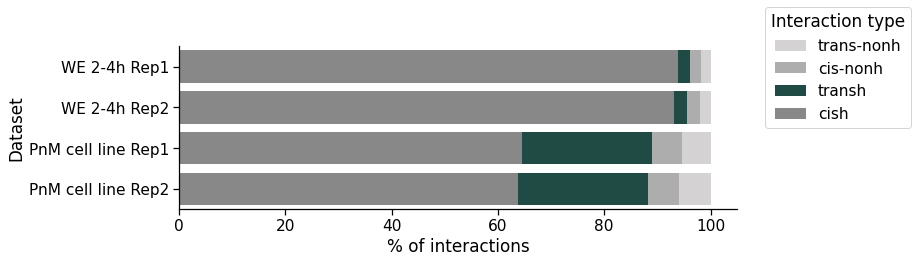

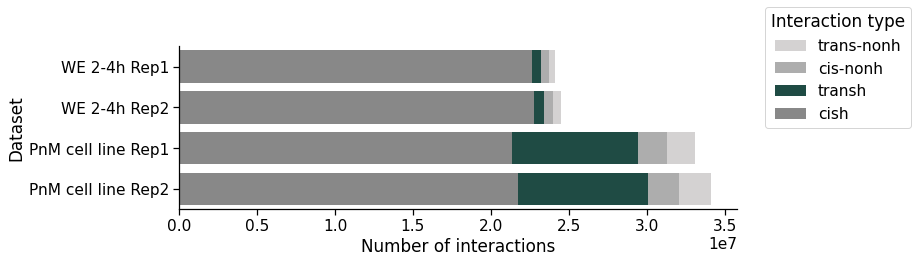

In [23]:
datasets_order = ["WE 2-4h Rep1", "WE 2-4h Rep2", "PnM cell line Rep1", "PnM cell line Rep2"]
with sns.plotting_context('notebook', font_scale=1.4):
    fig, ax = plt.subplots(1, 1, figsize=(10,3))
    bar1 = sns.barplot(y="Dataset", x="% cish + transh + cis-nonh + trans-nonh", data=summary2, label = "trans-nonh", color=contact_type_palette["trans-nonh"], orient="h", order = datasets_order)
    bar2 = sns.barplot(y="Dataset", x="% cish + transh + cis-nonh", data=summary2, label = "cis-nonh", color=contact_type_palette["cis-nonh"], orient="h", order = datasets_order)
    bar3 = sns.barplot(y="Dataset", x="% cish + transh", data=summary2, label = "transh", color=contact_type_palette["transh"], orient="h", order = datasets_order)
    bar4 = sns.barplot(y="Dataset",  x="% cish pairs", data=summary2, label = "cish", color=contact_type_palette["cish"], orient="h", order = datasets_order)

    ax.legend(title = "Interaction type", loc=(1.05, 0.5))
    ax.set_xlabel("% of interactions")
    sns.despine()
    plt.savefig(figures + "perc_interaction_types_Dmel.svg", bbox_inches='tight')
    
    fig, ax = plt.subplots(1, 1, figsize=(10,3))
    bar1 = sns.barplot(y="Dataset", x="Num cish + transh + cis-nonh + trans-nonh", data=summary2, label = "trans-nonh", color=contact_type_palette["trans-nonh"], orient="h", order = datasets_order)
    bar2 = sns.barplot(y="Dataset", x="Num cish + transh + cis-nonh", data=summary2, label = "cis-nonh", color=contact_type_palette["cis-nonh"], orient="h", order = datasets_order)
    bar3 = sns.barplot(y="Dataset", x="Num cish + transh", data=summary2, label = "transh", color=contact_type_palette["transh"], orient="h", order = datasets_order)
    bar4 = sns.barplot(y="Dataset",  x="Num cish pairs", data=summary2, label = "cish", color=contact_type_palette["cish"], orient="h", order = datasets_order)

    ax.legend(title = "Interaction type", loc=(1.05, 0.5))
    ax.set_xlabel("Number of interactions")
    sns.despine()
    plt.savefig(figures + "num_interaction_types_Dmel.svg", bbox_inches='tight')   

# Distribution of distances between pairs of loci depending on haplotype location

In [24]:
datasets_dict.keys()

dict_keys(['DGRP-57_DGRP-439_WE_2-4h_Rep1', 'DGRP-57_DGRP-439_PnM_Rep1', 'DGRP-57_DGRP-439_PnM_Rep2', 'DGRP-57_DGRP-439_WE_2-4h_Rep2'])

In [25]:
datasets_dict['DGRP-57_DGRP-439_WE_2-4h_Rep1'].head()

,chrom1,pos1,strand1,h1,chrom2,pos2,strand2,h2,interaction_ID,same haplotype,interaction type,dist,dist+1
0,chr3R,24607710,-,DGRP-57,chr3R,24701755,+,DGRP-57,0,True,cish DGRP-57,94045,94046
1,chr3R,15280387,-,DGRP-57,chr3R,15286147,+,DGRP-57,1,True,cish DGRP-57,5760,5761
2,chr2R,14955488,+,DGRP-57,chr2R,14955879,-,DGRP-57,2,True,cish DGRP-57,391,392
3,chr3R,19074941,-,DGRP-57,chr3R,19074677,+,DGRP-57,3,True,cish DGRP-57,264,265
4,chr2R,23600974,+,DGRP-57,chr2R,23588557,-,DGRP-57,4,True,cish DGRP-57,12417,12418


DGRP-57_DGRP-439_WE_2-4h_Rep1


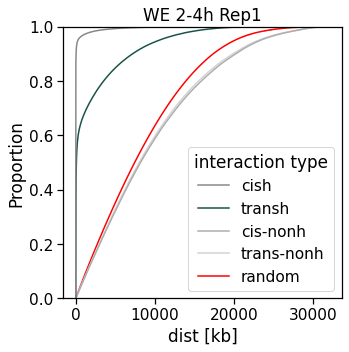

DGRP-57_DGRP-439_PnM_Rep1


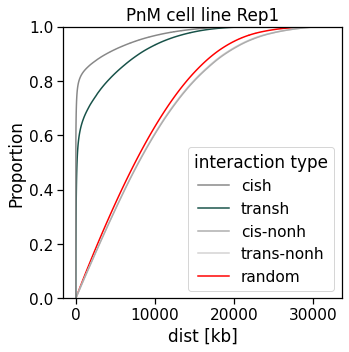

DGRP-57_DGRP-439_PnM_Rep2


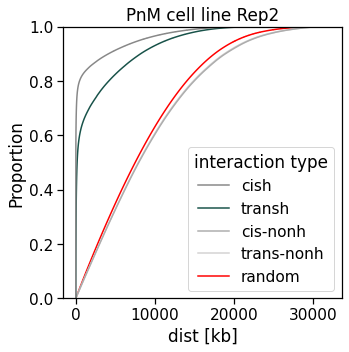

DGRP-57_DGRP-439_WE_2-4h_Rep2


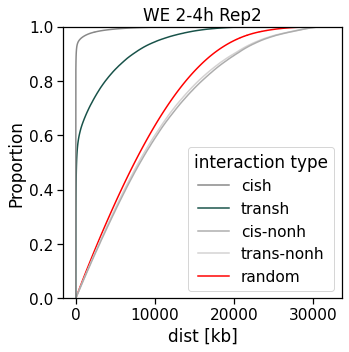

In [26]:
for dataset in datasets_dict.keys():
    print(dataset)
    plot_ecdf(datasets_dict[dataset], dataset_names_dict[dataset])